# LAB 6 : Recurrent Neural Networks

Name : Hrishikesh Pable

Roll Number : 200010037

Referrence Material : 

1. https://github.com/pangolulu/rnn-from-scratch
2. https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/


# **Problem 1** : Next Token Prediction in a Sequence

Observation to be demonstrated:

1. Generate the data required
2. Represent tokens as indices using dictionaries
3. Convert the tokens into vectors using One hot encoding
4. Implement Recurrent Neural Network to solve the Next token prediction problem

# Objective
The objective of the problem is to predict the next token in a sequence of tokens. 

So, mathematically,

Given a sequence of tokens, $x_1, x_2, x_3, ... x_n$, the objective is to predict the next token $x_{n+1}$.

The hypothesis is that the RNN model will be able to predict the next token in the sequence with a good accuracy. 

## Programming : 


1. **Representing tokens or text**

In previous labs we mainly considered data $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings.

2. **One-hot encoding over vocabulary**

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [1]:
import numpy as np


def generate_dataset(num_sequences=50):
    """
    Generates a number of sequences as our dataset.
    
    Input :
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    for i in range(num_sequences):
        sequence = []

        num_tokens = np.random.randint(1, np.floor((3/2)*num_sequences))
        sequence.extend(['a']*num_tokens)
        sequence.extend(['b']*num_tokens)
        sequence.append('EOS')

        samples.append(sequence)
        
    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [2]:
# from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Create word_to_idx and idx_to_word dictionaries for a list of sequences.
    """

    ## Write your code here
    word_to_idx = {}
    idx_to_word = {}
    
    for sequence in sequences:
        for word in sequence:
            if word not in word_to_idx:
                word_to_idx[word] = len(word_to_idx)
                idx_to_word[len(idx_to_word)] = word
                
    
    # Add the UNK token to the dictionaries
    word_to_idx['UNK'] = len(word_to_idx)
    idx_to_word[len(idx_to_word)] = 'UNK'
    
    num_sequences = len(sequences)
    vocab_size = len(word_to_idx)
                
    return word_to_idx, idx_to_word, num_sequences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print("Word to Index Dictionary : ",dict(word_to_idx))
print("Index to Word Dictionary : ",dict(idx_to_word))
print("Number of Sequences : ",num_sequences)
print("Vocab Size : ",vocab_size)


Word to Index Dictionary :  {'a': 0, 'b': 1, 'EOS': 2, 'UNK': 3}
Index to Word Dictionary :  {0: 'a', 1: 'b', 2: 'EOS', 3: 'UNK'}
Number of Sequences :  10
Vocab Size :  4


## Creating Dataset 

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training and test sets. 80% and 20% is a common distribution, but mind you that this largely depends on the size of the dataset. **Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.**

In [3]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y


 
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset, p_train=0.8, p_val=0.1, p_test=0.1)
    

print("Input for the first training sample : ",training_set.__getitem__(0)[0])
print("Target output for the first training sample : ",training_set.__getitem__(0)[1])


Input for the first training sample :  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Target output for the first training sample :  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [4]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Input :
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Input :
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' is {test_word}.')
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' is {test_sentence}.')
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')
print(test_sentence)

Our one-hot encoding of 'a' is [1. 0. 0. 0.].
Our one-hot encoding of 'a' has shape (4,).
Our one-hot encoding of 'a b' is [[[1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]]].
Our one-hot encoding of 'a b' has shape (2, 4, 1).
[[[1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]]]


## Implementation of RNN : 

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$


**Steps :** 

  1. Implement Forward Pass, Backward Pass and Optimisation
  2. Write the training loop
  3. Take care of the exploding gradient problem by clipping the gradients 

In [5]:
## Write your code here

hidden_size = 50 # Number of dimensions in the hidden state
vocab_size  = len(word_to_idx) # Size of the vocabulary used

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.

    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param


def init_rnn(hidden_size, vocab_size):
    """
    Initializes our recurrent neural network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
    """
    # Weight matrix (input to hidden state)
    # YOUR CODE HERE!
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    # YOUR CODE HERE!
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    # YOUR CODE HERE!
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    # YOUR CODE HERE!
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    # YOUR CODE HERE!
    b_out = np.zeros((vocab_size, 1))
    
    # Initialize weights
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    
    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)



In [6]:
def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

In [7]:
def forward_pass(inputs, hidden_state, params):
    """
    Computes the forward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `hidden_state`: an already initialized hidden state
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []
    
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        # YOUR CODE HERE!
        hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

        # Compute output
        # YOUR CODE HERE!
        out = softmax(np.dot(W, hidden_state) + b_out)
        
        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states


# Get first sequence in training set
test_input_sequence, test_target_sequence = training_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Now let's try out our new function
outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print('Input sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'EOS', 'EOS', 'UNK', 'UNK', 'UNK', 'EOS', 'EOS', 'EOS', 'EOS']


In [8]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads


def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Computes the backward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `outputs`: sequence of outputs from the forward pass
     `hidden_states`: sequence of hidden_states from the forward pass
     `targets`: sequence of targets
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Keep track of hidden state derivative and loss
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    # For each element in output sequence
    # NB: We iterate backwards s.t. t = N, N-1, ... 1, 0
    for t in reversed(range(len(outputs))):

        # Compute cross-entropy loss (as a scalar)
        # YOUR CODE HERE!
        loss += -np.mean(np.log(outputs[t]+1e-12) * targets[t])
        
        # Backpropagate into output (derivative of cross-entropy)
        # if you're confused about this step, see this link for an explanation:
        # http://cs231n.github.io/neural-networks-case-study/#grad
        # YOUR CODE HERE!
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Backpropagate into W
        # YOUR CODE HERE!
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        # Backpropagate into h
        # YOUR CODE HERE!
        d_h = np.dot(W.T, d_o) + d_h_next
        
        # Backpropagate through non-linearity
        d_f = tanh(hidden_states[t], derivative=True) * d_h
        d_b_hidden += d_f
        
        # Backpropagate into U
        # YOUR CODE HERE!
        d_U += np.dot(d_f, inputs[t].T)
        
        # Backpropagate into V
        # YOUR CODE HERE!
        d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    
    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

print("Loss for this example is: " + str(loss))

Loss for this example is: 8.011620500990217


In [9]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

Epoch 0, training loss: 6.3281677882915375, validation loss: 2.1145827057254025
Epoch 100, training loss: 5.952546349180071, validation loss: 2.0790259056453952
Epoch 200, training loss: 5.605242969785956, validation loss: 2.047236653912774
Epoch 300, training loss: 5.283467476227536, validation loss: 2.0181124245077275
Epoch 400, training loss: 4.985172719510257, validation loss: 1.9908522569105696
Epoch 500, training loss: 4.709158910380376, validation loss: 1.9649354383459925
Epoch 600, training loss: 4.454996501891497, validation loss: 1.9401091435316016
Epoch 700, training loss: 4.222587317369234, validation loss: 1.9163657000975913
Epoch 800, training loss: 4.0115793153113, validation loss: 1.8938964239213951
Epoch 900, training loss: 3.821031555483933, validation loss: 1.8730248914694636
Epoch 1000, training loss: 3.6494502143719085, validation loss: 1.8541308058997443
Epoch 1100, training loss: 3.4950113340358664, validation loss: 1.8375744504070188
Epoch 1200, training loss: 3

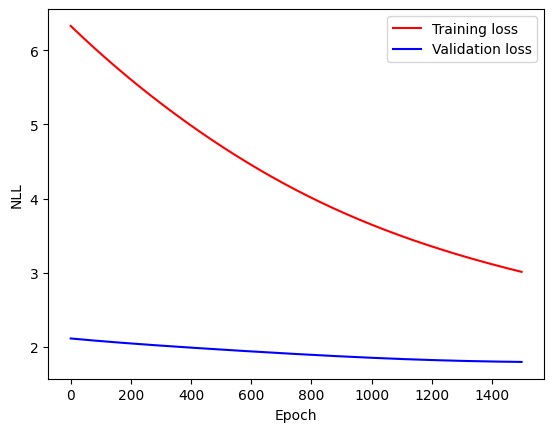

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 1500

# Initialize a new network
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
     # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE!
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        # YOUR CODE HERE!
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE!
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        # YOUR CODE HERE!
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished!')
        
        # Update parameters
        params = update_parameters(params, grads, lr=3e-4)
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 100 epochs
    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Get first sentence in test set
inputs, targets = test_set.__getitem__(0)

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

# **Problem 2** : Demonstrate the same for a Sine Wave

Objective : Given a sequence of 50 numbers belonging to a sine wave, predict the 51st number in the series.

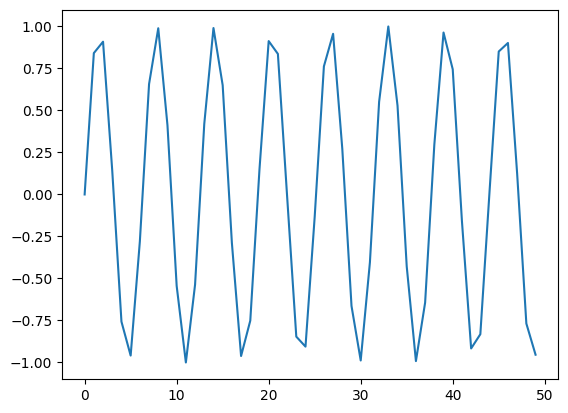

In [36]:
## Write your code here

import math

sin_wave = np.array([math.sin(x) for x in np.arange(200)])

plt.plot(sin_wave[:50])

In [37]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)


In [38]:
learning_rate = 0.001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [39]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [40]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [41]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])

    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s

        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[96457.89183637]] , Val Loss:  [[48227.21218231]]
Epoch:  2 , Loss:  [[36.86828559]] , Val Loss:  [[18.42608843]]
Epoch:  3 , Loss:  [[45.10166197]] , Val Loss:  [[22.55044969]]
Epoch:  4 , Loss:  [[46.52645774]] , Val Loss:  [[23.26070648]]
Epoch:  5 , Loss:  [[52.46388273]] , Val Loss:  [[26.23078295]]
Epoch:  6 , Loss:  [[47.53818131]] , Val Loss:  [[23.76766178]]
Epoch:  7 , Loss:  [[46.55778601]] , Val Loss:  [[23.27765242]]
Epoch:  8 , Loss:  [[46.3510167]] , Val Loss:  [[23.17457131]]
Epoch:  9 , Loss:  [[46.25572216]] , Val Loss:  [[23.12727115]]
Epoch:  10 , Loss:  [[46.18420703]] , Val Loss:  [[23.09190294]]
Epoch:  11 , Loss:  [[46.13562708]] , Val Loss:  [[23.06803353]]
Epoch:  12 , Loss:  [[46.11974135]] , Val Loss:  [[23.0605497]]
Epoch:  13 , Loss:  [[46.13703228]] , Val Loss:  [[23.06968556]]
Epoch:  14 , Loss:  [[46.19892527]] , Val Loss:  [[23.10114196]]
Epoch:  15 , Loss:  [[46.31943989]] , Val Loss:  [[23.16191227]]
Epoch:  16 , Loss:  [[46.43516

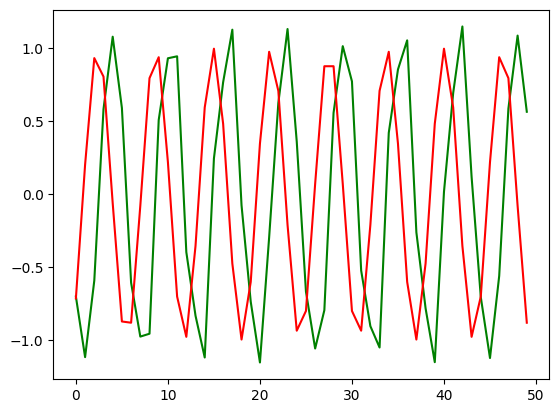

In [42]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

# Machine Translation: French -> English

In [1]:
# Importing.... 
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import os
import re
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download Data

In [2]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip

--2024-02-28 12:08:48--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  1001KB/s    in 23s     

2024-02-28 12:09:14 (334 KB/s) - ‘fra-eng.zip’ saved [7833145/7833145]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


## Preparing Vocabulary

In [6]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 5 # 20

#initialize Lang Class
class Lang:
   def __init__(self):
       #initialize containers to hold the words and corresponding index
       self.word2index = {}
       self.word2count = {}
       self.index2word = {0: "SOS", 1: "EOS"}
       self.n_words = 2  # Count SOS and EOS

   # split a sentence into words and add it to the container
   def addSentence(self, sentence):
       for word in sentence.split(' '):
           self.addWord(word)

  # If the word is not in the container, the word will be added to it, 
  # else, update the word counter
   def addWord(self, word):
       if word not in self.word2index:
           self.word2index[word] = self.n_words
           self.word2count[word] = 1
           self.index2word[self.n_words] = word
           self.n_words += 1
       else:
           self.word2count[word] += 1

## Preprocessing

In [7]:
# Normalize every sentence
def normalize_sentence(df, lang):
   sentence = df[lang].str.lower()
   sentence = sentence.str.replace('[^A-Za-z\s]+', '')
   sentence = sentence.str.normalize('NFD')
   sentence = sentence.str.encode('ascii', errors='ignore').str.decode('utf-8')
   return sentence

def read_sentence(df, lang1, lang2):
   sentence1 = normalize_sentence(df, lang1)
   sentence2 = normalize_sentence(df, lang2)
   return sentence1, sentence2

def read_file(loc, lang1, lang2):
   df = pd.read_csv(loc, sep='\t', header=None, 
                    names=[lang1, lang2, 'attribution'])
   return df

def process_data(file, lang1,lang2):
   df = read_file(file, lang1, lang2)
   print("Read %s sentence pairs" % len(df))
   sentence1, sentence2 = read_sentence(df, lang1, lang2)

   source = Lang()
   target = Lang()
   pairs = []
   for i in range(len(df)):
       if len(sentence1[i].split(' ')) < MAX_LENGTH and \
          len(sentence2[i].split(' ')) < MAX_LENGTH:
           full = [sentence1[i], sentence2[i]]
           source.addSentence(sentence1[i])
           target.addSentence(sentence2[i])
           pairs.append(full)

   return source, target, pairs

In [8]:
df = read_file('fra.txt', 'eng', 'fra')
df.head()

eng         fra                                        attribution
0  Go.        Va !  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1  Go.     Marche.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2  Go.  En route !  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3  Go.     Bouge !  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4  Hi.     Salut !  CC-BY 2.0 (France) Attribution: tatoeba.org #5...

## Read and Process Data

In [9]:
lang1 = 'eng'
lang2 = 'fra'
file = 'fra.txt'
source, target, pairs = process_data(file, lang1, lang2)

randomize = random.choice(pairs)
print('random sentence {}'.format(randomize))

# print number of words
input_size = source.n_words
output_size = target.n_words
print('Input : {}, Output : {}'.format(input_size, output_size))

Read 229803 sentence pairs


/tmp/ipykernel_288650/1061419661.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  sentence = sentence.str.replace('[^A-Za-z\s]+', '')


random sentence ['i like watermelon', 'jaime la pastque']
Input : 6412, Output : 11991


In [10]:
pairs[:5], pairs[-5:]

([['go', 'va '],
  ['go', 'marche'],
  ['go', 'en route '],
  ['go', 'bouge '],
  ['hi', 'salut ']],
 [['congratulations on your anniversary',
   'flicitations pour ton anniversaire'],
  ['im studying electrical engineering', 'jtudie le gnie lectrique'],
  ['their relationship is deteriorating', 'leur relation se dtriore'],
  ['he studies computational linguistics',
   'il tudie linformatique linguistique'],
  ['thirteen passengers were hospitalized',
   'treize passagres furent hospitalises']])

In [11]:
ids = [0, 2, 5, 10, 40]
for i in ids:
  print(f'id {i}, source: {source.index2word[i]}')

ids = [12, 22, 34, 11, 42]
for i in ids:
  print(f'id {i}, target: {target.index2word[i]}')

id 0, source: SOS
id 2, source: go
id 5, source: who
id 10, source: hide
id 40, source: hunt
id 12, target: filez
id 22, target: baissezvous
id 34, target: commencez
id 11, target: file
id 42, target: aha


In [12]:
target.word2index['je'], source.word2index['i']

(40, 17)

In [13]:
target.word2count['suis'], source.word2count['am']

(1266, 144)

## Tensors from sentences

In [14]:
def indexesFromSentence(lang, sentence):
   return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
   indexes = indexesFromSentence(lang, sentence)
   indexes.append(EOS_token)
   return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(input_lang, output_lang, pair):
   input_tensor = tensorFromSentence(input_lang, pair[0])
   target_tensor = tensorFromSentence(output_lang, pair[1])
   return (input_tensor, target_tensor)

In [15]:
sentence = pairs[1000][0]
l = source
for word in sentence.split(' '):
  print(word, l.word2index[word])

he 85
is 295
old 296


In [16]:
in_t, out_t = tensorsFromPair(source, target, pairs[1000])
print(pairs[1000])
print(in_t)
print(out_t)

['he is old', 'il est vieux']
tensor([[ 85],
        [295],
        [296],
        [  1]], device='cuda:0')
tensor([[127],
        [243],
        [689],
        [  1]], device='cuda:0')


## Encoder

In [17]:
class Encoder(nn.Module):
   def __init__(self, input_dim, hidden_dim, embedding_dim, num_layers):
       super(Encoder, self).__init__()
      
       # set the encoder input dimension, embedding dimension, 
       # hidden dimesion, and number of layers 
       self.input_dim = input_dim
       self.embedding_dim = embedding_dim
       self.hidden_dim = hidden_dim
       self.num_layers = num_layers

       #initialize the embedding layer with input and embedding dimension
       self.embedding = nn.Embedding(input_dim, self.embedding_dim)
       
       # intialize the GRU to take the input dimension of embedding, and output 
       # dimension of hidden and set the number of gru layers
       self.gru = nn.GRU(self.embedding_dim, self.hidden_dim, 
                         num_layers=self.num_layers)
              
   def forward(self, input, hidden):
       embedded = self.embedding(input).view(1,1,-1)
       outputs, hidden = self.gru(embedded, hidden)
       return outputs, hidden
  
   def init_hidden(self):
      return torch.zeros(self.num_layers, 1, self.hidden_dim)

## Decoder

In [18]:
class Decoder(nn.Module):
   def __init__(self, output_dim, hidden_dim, embedding_dim, num_layers):
       super(Decoder, self).__init__()

       # set the encoder output dimension, embedding dimension, 
       # hidden dimension, and number of layers 
       self.embedding_dim = embedding_dim
       self.hidden_dim = hidden_dim
       self.output_dim = output_dim
       self.num_layers = num_layers

       # initialize every layer with the appropriate dimension. 
       # For the decoder layer, it will consist of an embedding, 
       # GRU, a Linear layer and a Log softmax activation function.
       self.embedding = nn.Embedding(output_dim, self.embedding_dim)
       self.gru = nn.GRU(self.embedding_dim, self.hidden_dim, 
                         num_layers=self.num_layers)
       self.out = nn.Linear(self.hidden_dim, output_dim)
       self.softmax = nn.LogSoftmax(dim=1)
      
   def forward(self, input, hidden):
       # reshape the input to (1, batch_size)
       input = input.view(1, -1)
       embedded = F.relu(self.embedding(input))
       output, hidden = self.gru(embedded, hidden)       
       prediction = self.softmax(self.out(output[0]))
       
       return prediction, hidden

## Seq2Seq Model

In [19]:
class Seq2Seq(nn.Module):
   def __init__(self, encoder, decoder, device):
       super().__init__()
      
       # initialize the encoder and decoder
       self.encoder = encoder
       self.decoder = decoder
       self.device = device
       self.encoder_hidden = self.encoder.init_hidden().to(self.device)

   def forward(self, source, target, teacher_forcing_ratio=0.5):
       # get the input length (number of words in sentence)
       input_length = source.size(0) 
       
       batch_size = source.shape[1] # target.shape[1]
       target_length = target.shape[0]

       vocab_size = self.decoder.output_dim
      
       # initialize a variable to hold the predicted outputs
       outputs = torch.zeros(target_length, batch_size, 
                             vocab_size).to(self.device)

       # encode every word in a sentence
       encoder_hidden = self.encoder_hidden 
       for i in range(input_length):
           encoder_output, encoder_hidden = self.encoder(source[i], 
                                                         encoder_hidden)

       # use the encoder’s hidden state as the decoder initial hidden state
       decoder_hidden = encoder_hidden.to(device)
  
       # add a token before the first predicted word
       decoder_input = torch.tensor([SOS_token], device=device)  # SOS

       # topk is used to get the top K value over a list
       # predict the output word from the current target word. 
       # If we enable the teaching force,  then the #next decoder input is the 
       # next word, else, use the decoder output highest value. 
       for t in range(target_length):   
           decoder_output, decoder_hidden = self.decoder(decoder_input, 
                                                         decoder_hidden)
           outputs[t] = decoder_output
           teacher_force = random.random() < teacher_forcing_ratio
           topv, topi = decoder_output.topk(1)
           decoder_input = (target[t] if teacher_force else topi)
           if (teacher_force == False and decoder_input.item() == EOS_token):
               break

       return outputs

In [20]:
embed_size = 256
hidden_size = 512
num_layers = 1
num_iteration = 50000

#create encoder-decoder model
encoder = Encoder(input_size, hidden_size, embed_size, num_layers)
decoder = Decoder(output_size, hidden_size, embed_size, num_layers)

model = Seq2Seq(encoder, decoder, device).to(device)

In [21]:
#print model 
print(encoder)
print(decoder)

Encoder(
  (embedding): Embedding(6412, 256)
  (gru): GRU(256, 512)
)
Decoder(
  (embedding): Embedding(11991, 256)
  (gru): GRU(256, 512)
  (out): Linear(in_features=512, out_features=11991, bias=True)
  (softmax): LogSoftmax(dim=1)
)


## Training the Seq2Seq Model

In [22]:
teacher_forcing_ratio = 0.5

# Training step and return loss 
def model_step(model, input_tensor, target_tensor, model_optimizer, criterion):
   model_optimizer.zero_grad()

   input_length = input_tensor.size(0)
   loss = 0
   epoch_loss = 0

   output = model(input_tensor, target_tensor)
   num_iter = output.size(0)

   # calculate the loss from a predicted sentence with the expected result
   for ot in range(num_iter):
       loss += criterion(output[ot], target_tensor[ot])

   loss.backward()
   model_optimizer.step()
   epoch_loss = loss.item() / num_iter

   return epoch_loss

# Training Loop 
def trainModel(model, source, target, pairs, num_iteration=20000):
   model.train()

   optimizer = optim.SGD(model.parameters(), lr=0.01)
   criterion = nn.NLLLoss()
   total_loss_iterations = 0

   training_pairs = [tensorsFromPair(source, target, random.choice(pairs))
                     for i in range(num_iteration)]
  
   for iter in range(1, num_iteration+1):
       training_pair = training_pairs[iter - 1]
       input_tensor = training_pair[0]
       target_tensor = training_pair[1]

       loss = model_step(model, input_tensor, target_tensor, 
                         optimizer, criterion)

       total_loss_iterations += loss

       if iter % 500 == 0:
           avarage_loss= total_loss_iterations / 5000
           total_loss_iterations = 0
           print('%d %.4f' % (iter, avarage_loss))
          
   return model

In [23]:
model = trainModel(model, source, target, pairs, num_iteration)

500 0.5214
1000 0.5384
1500 0.5229
2000 0.5145
2500 0.4988
3000 0.4822
3500 0.4848
4000 0.4662
4500 0.4666
5000 0.4614
5500 0.4610
6000 0.4508
6500 0.4416
7000 0.4451
7500 0.4314
8000 0.4233
8500 0.4174
9000 0.4263
9500 0.4116
10000 0.4030
10500 0.3966
11000 0.4020
11500 0.4031
12000 0.3956
12500 0.4020
13000 0.3973
13500 0.3832
14000 0.3861
14500 0.3841
15000 0.3796
15500 0.3668
16000 0.3704
16500 0.3682
17000 0.3722
17500 0.3548
18000 0.3655
18500 0.3494
19000 0.3545
19500 0.3472
20000 0.3502
20500 0.3494
21000 0.3454
21500 0.3305
22000 0.3353
22500 0.3350
23000 0.3333
23500 0.3289
24000 0.3236
24500 0.3174
25000 0.3188
25500 0.3096
26000 0.3154
26500 0.3159
27000 0.3079
27500 0.3109
28000 0.3045
28500 0.3004
29000 0.3195
29500 0.3006
30000 0.2862
30500 0.2982
31000 0.2891
31500 0.2895
32000 0.2977
32500 0.2859
33000 0.2856
33500 0.2860
34000 0.2870
34500 0.2781
35000 0.2889
35500 0.2773
36000 0.2834
36500 0.2757
37000 0.2814
37500 0.2708
38000 0.2743
38500 0.2825
39000 0.2668
39500 

In [24]:
eng_eg, fra_eg = random.choice(pairs)
eng_eg, fra_eg

('show me your hands', 'montrezmoi vos mains')

In [25]:
input_tensor = tensorFromSentence(source, eng_eg)
output_tensor = tensorFromSentence(target, fra_eg)

In [26]:
output = model(input_tensor, output_tensor)
output, output.shape

(tensor([[[-11.2471, -14.6182,  -7.7197,  ..., -12.1450, -11.3805, -11.6743]],
 
         [[-13.8141,  -8.3680,  -9.8897,  ..., -13.8308, -13.7653, -13.5783]],
 
         [[-13.5060, -10.7426, -13.2951,  ..., -13.6359, -13.3900, -13.8403]],
 
         [[-11.7364,  -1.0048, -10.0167,  ..., -11.4796, -11.5760, -11.6856]]],
        device='cuda:0', grad_fn=<CopySlices>),
 torch.Size([4, 1, 11991]))

In [27]:
output[0].topk(1)

torch.return_types.topk(
values=tensor([[-1.9463]], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[335]], device='cuda:0'))

In [28]:
decoded_words = []
for ot in range(output.size(0)):
    top_value, top_index = output[ot].topk(1)

    if top_index[0].item() == EOS_token:
        decoded_words.append('<EOS>')
        break
    else:
        word = target.index2word[top_index[0].item()]
        decoded_words.append(word)
        print(top_index, word)

tensor([[335]], device='cuda:0') montrezmoi
tensor([[635]], device='cuda:0') tes
tensor([[5949]], device='cuda:0') mains


In [29]:
decoded_words

['montrezmoi', 'tes', 'mains', '<EOS>']

## Evaluate Model Predictions

In [30]:
def evaluate(model, input_lang, output_lang, sentences, max_length=MAX_LENGTH):
   with torch.no_grad():
       input_tensor = tensorFromSentence(input_lang, sentences[0])
       output_tensor = tensorFromSentence(output_lang, sentences[1])
  
       decoded_words = []
  
       output = model(input_tensor, output_tensor, teacher_forcing_ratio=0)
  
       for ot in range(output.size(0)):
           topv, topi = output[ot].topk(1)

           if topi[0].item() == EOS_token:
               decoded_words.append('<EOS>')
               break
           else:
               decoded_words.append(output_lang.index2word[topi[0].item()])
   return decoded_words

def evaluateRandomly(model, source, target, pairs, n=10):
   for i in range(n):
       pair = random.choice(pairs)
       print('source: {}'.format(pair[0]))
       print('target: {}'.format(pair[1]))
       output_words = evaluate(model, source, target, pair)
       output_sentence = ' '.join(output_words)
       print('predicted: {}'.format(output_sentence))
       print('----')

In [31]:
evaluateRandomly(model, source, target, pairs)

source: i drink a lot
target: je bois beaucoup
predicted: je sais beaucoup <EOS>
----
source: you must control yourself
target: vous devez vous contrler
predicted: vous devez te dpcher <EOS>
----
source: this doesnt fit
target: a ne colle pas
predicted: a ne pas pas <EOS>
----
source: im first
target: je suis en premier
predicted: je suis en <EOS>
----
source: correct the underlined words
target: corrige les mots souligns
predicted: voil les prix <EOS>
----
source: i forgot my key
target: jai oubli ma cl
predicted: jai oubli mon cl <EOS>
----
source: shes an angel
target: cest un ange
predicted: elle est un <EOS>
----
source: time is running out
target: le temps spuise
predicted: le temps est <EOS>
----
source: its warm in here
target: il fait chaud ici
predicted: cest chaud chaud <EOS>
----
source: im against it
target: je suis contre
predicted: je suis contre <EOS>
----


## Inferences and Conclusion : State all the key observations and conclusion

1. In order to predict the next token in a sequence, we need to represent the tokens as indices using dictionaries and convert the tokens into vectors using One hot encoding.

2. The RNN model predicts the next token in the sequence given the sequence of previous tokens.

3. Clipping the gradients ensure that they do not explode or vanish during the training process.

4. We can perform Machine Translation using a Seq2Seq model which is a combination of Encoder and Decoder made using RNNs.